# Open-Science-prize quantum challenge 2021/22 by Quantum Polo Gang (Amico Valerio, Bensch Fabio,Pariente Ruben)

# Note


Our solution is for the Qiskit default challenge.


In chapter 3 we specify which solution we choose for the fidelity score

# Abstract

We decide to split the XXX Hamiltonian into two pieces $H=H_1+H_2$ (instead of 6):
$$    H_1=I^{(0)} \otimes \sigma_x^{(1)} \otimes \sigma_x^{(2)}  + I^{(0)}  \otimes  \sigma_y^{(1)} \otimes \sigma_y^{(2)} + I^{(0)}  \otimes \sigma_z^{(0)} \otimes \sigma_z^{(1)}$$
$$ H_2=\sigma_x^{(0)}\otimes \sigma_x^{(1)} \otimes I^{(2)}  +  \sigma_y^{(0)} \otimes \sigma_y^{(1)} \otimes I^{(2)} + \sigma_z^{(0)} \otimes \sigma_z^{(1)} \otimes I^{(2)}$$

so using Trotter's formula (for a fixed number of steps $N$):
$$ e^{-iHt}=e^{-i(H_1 + H_2)t} \simeq \left(e^{-iH_1\frac{t}{N}}e^{-iH_2\frac{t}{N}}\right)^N \equiv (T_{step})^N \equiv T(t)$$

The main idea is to use Unitary Decomposition in a similar way as proposed in "https://arxiv.org/abs/2101.02993", instead of repeat a single $T_{step}$ N times that increase drastically the depth of the circuit. In particular instead of using Quantum Shannon decomposition (QSD) we look for a Unitary Decomposition for which the gate $T_{step}^{n}$ has the same minimal depth for every time simulation and number of Trotter Steps.

In conclusion we are looking for a gate $U_{best}$ such that:
$$U_{best}(t) \ket{110} = T(t) \ket{110}$$

This can be intended in two ways:

* $U_{best} = T$ (equality between operators)
* $U_{best} \neq T$, but the two different operators applied to the same vector yield the same result

We followed both approaches, the former will be called *Hilbert Space Decomposition* (HSD) while for the latter we chose the name of *Single State Decomposition* (SSD).

For HSD the best circuit we found is composed of 11 cnots (14 for the Jakarta geometry) while for the SSD approach we reached an even better 4 cnots solution.

Furthermore, referring to qiskit's measurement error mitigation strategy (*https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html*), we tried to model also the noise introduced by the circuit instead of narrowing ourselves down to measurement error only.

# 1) Decompositions

We suggest two possible decomposition methods. Both are attempts to reconduce the trotterized evolution to two-qubit gates, since those are decomposed more efficiently. 

## 1.1) Single State Decomposition

We start from observing that the hamiltonian preserves the magnetization:
$$m = \sum_i \sigma_z^{(i)}\; ; \;\;\;  [H,m]=0$$
We want to implement  a 3-qubit magnetization invariant gate using two 2-qubit gates in succession that preserve the magnetization too.
$$U_{best} = \left( \mathbb{I}^{(0)} \otimes M^{(1,2)} \right) \cdot \left( M^{(0,1)} \otimes \mathbb{I}^{(2)}  \right)  $$
We search thus the most general form of a 2-qubit magnetization-preserving gate.
Following https://arxiv.org/pdf/2106.13839.pdf, we want to generalize the Givens Rotation Gate to a SU(2) operator in the subspace $\ket{01},\ket{10}$:

$$ M(\omega,\theta, \phi) = \left[\begin{matrix}e^{ -i \left( \phi + \theta\right)} & 0 & 0 & 0\\ 0 & e^{-  i \left(\phi + \theta\right)} \cos{\left(\omega \right)} & - e^{-  i \left( \phi - \theta\right)} \sin{\left(\omega \right)} & 0\\ 0 & e^{ i \left( \phi - \theta\right)} \sin{\left(\omega \right)} & e^{ i \left( \phi + \theta\right)} \cos{\left(\omega \right)} & 0\\ 0 & 0 & 0 & e^{ i \left( \phi + \theta\right)}\end{matrix}\right] $$

The M gate can be decompose with just 2 c-nots.

Fixed the initial state to $\ket{110}$, we have that $M^{(1,2)}M^{(0,1)}\ket{110}$ spans the whole magnetization eigenspace. 
$$U_{best} = \left(  \mathbb{I} \otimes M(\omega_2,\theta_2, \phi_2)\right)     \cdot     \left( M(\omega_1,\theta_1, \phi_1) \otimes \mathbb{I} \right)   $$

So taking: $$T\ket{110} = \alpha \ket{011} + \beta \ket{101} + \gamma \ket{110}$$

where the $T(t)$ matrix is computed numerically and: 

$$\begin{align*}

U_{best}\ket{110} =\; &e^{i(\theta_1 - \phi_1 + \theta_2 - \phi_2)}\sin(\omega_1)\sin(\omega_2) \ket{011} +\\
& e^{i(\theta_1-\phi_1-\theta_2-\phi_2-\pi)}\sin(\omega_1)\cos(\omega_2) \ket{101} + \\
&e^{i(\theta_1+\phi_1+\theta_2+\phi_2)}\cos(\omega_2) \ket{110}

\end{align*}$$

Matching the amplitudes and solving the system for $\{\omega, \theta, \phi \}_{1,2}$ we get the parameters for the gates $M^{(0,1)}$ and $M^{(1,2)}$.


## Circuits:

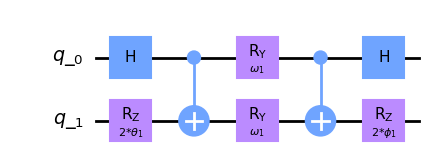

In [16]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

def get_M(theta, phi, omega, name="M"): # defining the M matrix

    qr=QuantumRegister(2, name="q_")
    M_qc=QuantumCircuit(qr, name=name)

    M_qc.rz(2*theta,qr[1])
    M_qc.h(qr[0])
    M_qc.cx(qr[0],qr[1])
    M_qc.ry(omega,qr)
    M_qc.cx(qr[0],qr[1])
    M_qc.h(qr[0])
    M_qc.rz(2*phi,qr[1])

    return M_qc

theta_1, phi_1, omega_1  = Parameter(r'$\theta_1$'), Parameter(r'$\phi_1$'), Parameter(r'$\omega_1$')

M1_qc = get_M(theta_1, phi_1, omega_1, name=r"$M_1$")

M1_qc.draw(output="mpl", style={"figwidth":6, "fontsize":11})

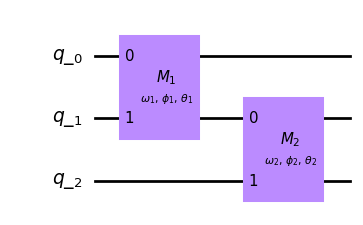

In [17]:
theta_2, phi_2, omega_2  = Parameter(r'$\theta_2$'), Parameter(r'$\phi_2$'), Parameter(r'$\omega_2$')
M2_qc = get_M(theta_2, phi_2, omega_2, name=r"$M_2$")

#building the circuit for the single state decomposition (SSD)
qr_SSD = QuantumRegister(3, name = "q_")
qc_SSD = QuantumCircuit(qr_SSD, name = r"$U_{best}$")

qc_SSD.append(M1_qc, [qr_SSD[0], qr_SSD[1]])
qc_SSD.append(M2_qc, [qr_SSD[1], qr_SSD[2]])

qc_SSD.draw(output = "mpl", style={"figwidth":5, "fontsize":11})

## 1.2) Hilbert Space Decomposition
This decomposition is based on the observation that the single trotter step can be reduced to  2 qubit gate by a permutation of the basis elements $B T_{step} B^{\dagger}=\mathbb{I}^{(2)} \otimes D^{(1,0)}_{step}$

so for the iteration:

$$B T_{step}^N B^{\dagger} = \mathbb{I} \otimes D =T_{B}(t)$$

where $D=D_{step}^{N}$ and $B$ is the matrix associated with the permutation $\left(\begin{matrix}0 & 1 & 2 & 3 & 4\\3 & 2 & 1 & 4 & 0 \end{matrix}\right)$, that in matrix form is

$$B = \left[
\begin{matrix}
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\end{matrix}
\right]$$

Therefore

$$ T_{B}(t) = B T(t) B^{\dagger}$$

So the final circuit is
$$T= B^{\dagger}\left(\mathbb{I} \otimes D\right) B$$


Since the initial state is just a permutation of the prepared state, we can prepare it already in the permutated one.
$$ \ket{\psi}_{prepared} = B\ket{\psi}_{init} $$

Then we use `qiskit.transpile()` function to decompose $D$ (up to 3 c-nots), and we find the circuit for B using the permutation gates: x, c-not and toffoli.

We also note that $B\ket{110} = \ket{110}$

This decomposition works for a generic overlap of the Hilbert Space


## Circuits:

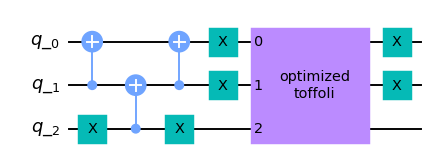

In [18]:
import numpy as np
from lib import utilities
# Loads the permutation operator and the matrix associated to this circuit
from lib.utilities import B_qc, B

B_qc.draw(output="mpl", style={"figwidth":6, "fontsize":15})

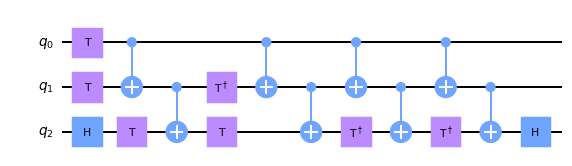

In [19]:
# where the toffoli gate is optimized for the Jakarta geometry.
utilities.Toffoli_gate.draw(output="mpl", style={"figwidth":8, "fontsize":11})

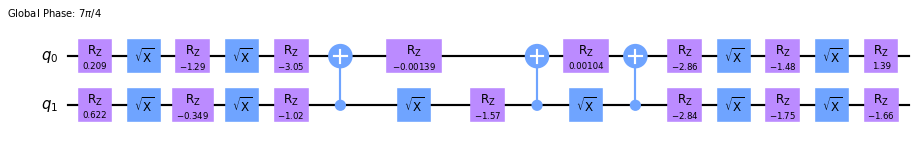

In [20]:
# The matrix D is a block of B' T B

# To avoid code redundancy, we defined the trotter operation 
# in the external script utilities.py
N_STEPS = 99
TIME = np.pi

T = utilities.trotterized_matrix(TIME, N_STEPS)
T_b = np.linalg.multi_dot([ B, T, B.transpose() ])

D = T_b[0:4, 0:4]

from qiskit import transpile
# Transpile the D operator and build the evolution circuit
D_qc = QuantumCircuit(2, name="D")
D_qc.unitary(D,[0,1])    
D_qc = transpile(D_qc, basis_gates=['cx','x','sx','rz']) # Jackarta basis gates

D_qc.draw(output="mpl", style={"figwidth":13, "fontsize":11})

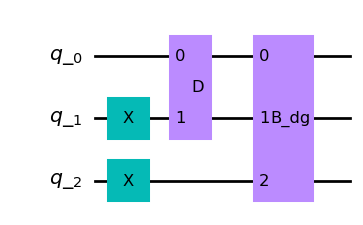

In [21]:
qr_HSD = QuantumRegister(3, name="q_")
qc_HSD = QuantumCircuit(qr_HSD, name="D")

# the permutation of 110 is 110 itself, so we prepare it.
initial_state = "110"

for qubit in range(3):
    if initial_state[::-1][qubit] == "1":
        qc_HSD.x(qr_HSD[qubit])

qc_HSD.append(D_qc, [qr_HSD[0], qr_HSD[1]])
qc_HSD.append(B_qc.inverse(), qr_HSD)
# hilbert space decomposition evolution circuit
qc_HSD.draw(output="mpl", style={"figwidth":5, "fontsize":12})

# Comparison between SSD and HSD

SSD has 4 c-not while HSD 14 c-not (for Jakarta geometry) but, at fixed time of evolution, SSD circuit has to be redefined every time we want to change the initial state.

In addition it has no solution if we inizialize the system in a overlap of states with different magnetizations, while once we have the circuit for HSD this can be use for a generic initial state.

From the chapter 3 you will see that, due to mitigation methods, there's no remarkable differences in terms of fidelity score between SSD and HSD.

Between two different decomposition with same performance, we choose HSD as best solution because is the simplest and most general method.  

# 2) Mitigation

The following haphazard processes affect the performance of the circuit:
* measurement noise
* gate noise
* state preparation noise 

we neglect the noise introduced by state mispreparation, so we assume the following model:

$$ \vec{p_{n}} = \|U_{noisy}\| \vec{p_{0}} = C \|U\| \vec{p_{0}}  = C \vec{p_{i}} $$

Where $\vec{p}_n$ and $\vec{p}_i$ are the probability vector noisy and ideal, C is a stochastic matrix that represent the noise of circuit and measure.
We use $ \|U\|$ to intend the probability matrix (or Unistochastic) of U $$\|U\|_{ij}=|U_{ij}|^{2}$$


So, characterizing the Calibration Matrix C we can mitigate the raw results. In particular because the shape of the circuit is the same for every time simulation (not only for $\pi$) we can use the Calibration matrix computed for a particular time $t_{0}$ for every time. This is verified in the file "nome_file"
$$C(t_{0})\approx C(t)$$
For this particular case we computed $C(\pi)$

## 2.1) *Circuit Itself Calibration* (CIC)

We can caracterize the matrix $ \tilde{U} = C\|U\| $, just preparing all the $2^n$ computational basis states and evolve them with the circuit $U_{noisy}$ itself.
$$ \tilde{U}_{ij} =   (C\|U\|)_{ij} $$

So, the *calibration matrix* is:
$$ C = \tilde{U} \| U \|^{-1}  = C  \|U\| \|U\|^{-1}  $$

We note that if $||U||$ is not invertible must be excluded from this treatment  ($t=\pi$ is not the case). 
## Circuits:

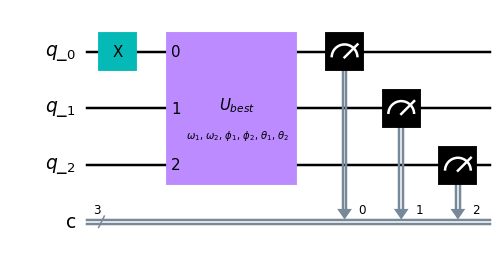

In [22]:
calib_circuits_CIC = []

state_labels = ['000', '001', '010', '011', '100', '101', '110', '111']  

for state in state_labels:
    cr_cal_itself = ClassicalRegister(3, name = "c")
    qr_cal_itself = QuantumRegister(3, name = "q_")
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{state}")
    # first we prepare the initial state.
    for qubit in [0,1,2]:
        if state[::-1][qubit] == "1":
            qc_cal_itself.x(qr_cal_itself[qubit])
    # then we append the circuit.
    qc_cal_itself.append(qc_SSD, qr_cal_itself)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_CIC.append(qc_cal_itself)
# example: for i = 1 we should preper the state |001> (gate x on first qubit).
calib_circuits_CIC[1].draw(output="mpl", style={"figwidth":7, "fontsize":12})


## 2.2) *Noisy Identity Calibration* (NIC)
In order to evaluate $C$ without the use of the ideal matrix (that could be a problem for more qubits), for all computational base states we use the following scheme:
* prepare the initial state in an eigenvector of $U$: $U\ket{\lambda} = \lambda \ket{\lambda}$.
* apply U
* apply a state preparation operator $O_{i, \lambda}$ such that: $O_{i, \lambda} \ket{\lambda} = \ket{i}$, where $\ket{i}$ is the i-th state of the computational basis.

So, running the circuits:
$$ C_{i,j} = \bra{j} C O_{i, \lambda}U \ket{\lambda} = \bra{j} C \ket{i} $$ 

For this specific case $\ket{000},\ket{111}$ are both eigenvector for SSD and only $\ket{111}$ for HSD.

If we assume that the gate noise doesn't depend on time, we can use the same calibration matrix (obtained with 8 circuits), to mitigate all the results of a temporal evolution (see pdf or .py script).

Note that NIC doesn't need to calculate numerically $||U||^{-1}$, so it's less computationally expensive compare to CIC method.
## Circuits:

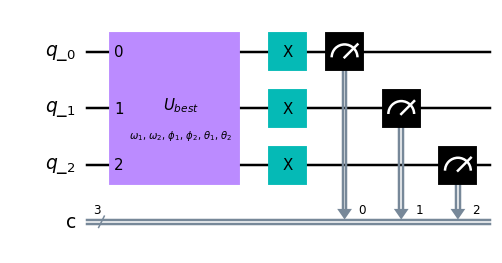

In [23]:
calib_circuits_NIC = []

for state in state_labels:
    cr_cal_id = ClassicalRegister(3, name = "c")
    qr_cal_id = QuantumRegister(3, name = "q_")
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{state}")
    # The eigenvector of U_best is |000> so we prepare it.
    # first we append the circuit.
    qc_cal_id.append(qc_SSD, qr_cal_id)
    # than we permute the state.
    for qubit in range(3):
        if state[::-1][qubit] == "1":
            qc_cal_id.x(qr_cal_id[qubit])

    qc_cal_id.measure(qr_cal_id, cr_cal_id)

    calib_circuits_NIC.append(qc_cal_id)
# example: for i = 7 we should get the final state |111> (gate x on all qubits).
calib_circuits_NIC[7].draw(output="mpl", style={"figwidth":7, "fontsize":12})


### *Fast Tomography Circuits Calibration*

Using NIC or CIC for each tomography base we should run $2^n$ circuit to calibrate it, so the total number of run would be $2^n \cdot 3^n$ calibration circuits, that is computationally high-expensive.

The *Fast Tomography Circuits Calibration* needs only $2^n$ calibration circuits.

The idea is to compute just once the calibration matrix in the computational basis and for every tomography basis compute $$C_{H}=\|H\|C\|H^{\dagger}\|$$ where H is the new basis matrix.

Clearly, if the calibration matrix does not dipend on time in the computational basis, also $C_H$ has this properties.

If for example we want to see the evolution at 50 differents values of time, with this procedure we don't need to measure the calibration matrix for all the times and then calculate the changes of bases, but we just need to do it for fixed time and then apply the calibration matrices we got to the results at different time.

So, instead of 50*27 operations we need only 27

# Mitigation with Ancillas
Since parity and total magnetization are conserved during time evolution, we try to measure with ancillas those quantities and reject all measurements that does not respect those constrains.

The circuits that we have to append to use the ancillas are equally or more deep than the time evolution circuit itself so we have no improvement, in fidelity's terms, in using ancillas.  

# 3) Results

Next we run both the NIC and CIC method, with the single state decomposition. But for the challenge we choose the CIC technique.

## 3.1) *Single State Decomposition* results

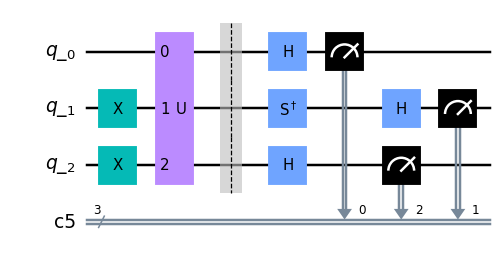

In [24]:
import numpy as np
from scipy.linalg import expm

# defining the evolution paramiters
N_Trotter_Steps = 99
evolution_time = np.pi

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the two hamiltonian pizes: 
H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.
trotter_step_matrix_= expm(-evolution_time/N_Trotter_Steps*H1*1j).dot(expm(-evolution_time/N_Trotter_Steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, N_Trotter_Steps)

# getting the parameters for the gates M1 and M2, solving the equations described in 1.1).
theta_1, theta_2, phi_1, phi_2, omega_1, omega_2 = utilities.get_gates_parameters(trotterized, initial_state={"110": 1.0})
# build M1 and M2
M1_qc = get_M(theta_1, phi_1, omega_1)
M2_qc = get_M(theta_2, phi_2, omega_2)
# define the circuit of U
qr_U = QuantumRegister(3 ,name="q_")
qc_U = QuantumCircuit(qr_U, name="U")
# append the gates
qc_U.append(M1_qc, [qr_U[0], qr_U[1]])
qc_U.append(M2_qc, [qr_U[1], qr_U[2]])
# transpile and draw the circuit
from qiskit import transpile
qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
# building the tomography circuits
qr_SSD = QuantumRegister(3, name="q_")
qc_SSD = QuantumCircuit(qr_SSD, name=r"$U_{best}$")

qc_SSD.x([qr_SSD[1],qr_SSD[2]])
qc_SSD.append(qc_U, qr_SSD)

from qiskit.ignis.verification.tomography import state_tomography_circuits
# make the tomography circuits
qcs_tomo = state_tomography_circuits(qc_SSD, qr_SSD)
qcs_tomo[3].draw(output="mpl", style={"figwidth":7, "fontsize":12})

In [25]:
# building the calibration circuits
calib_circuits_NIC = utilities.get_calibration_circuits(qc_U, method="NIC", eigenvector="000") ### ATTENZIONE NON FUNZIONA PER HSD |111>
calib_circuits_CIC = utilities.get_calibration_circuits(qc_U, method="CIC")

from qiskit import IBMQ, execute
from qiskit.providers.aer import QasmSimulator

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')

shots = 20000
# execute the jobs.
job_tomography=execute(qcs_tomo, backend_sim_noisy_jakarta, shots=shots, initial_layout=[1,3,5])
job_NIC=execute(calib_circuits_NIC, backend = backend_sim_noisy_jakarta, shots=shots, initial_layout=[1,3,5])
job_CIC=execute(calib_circuits_CIC, backend = backend_sim_noisy_jakarta, shots=shots, initial_layout=[1,3,5])

ibmqfactory.load_account:WARNING:2022-04-13 14:07:32,180: Credentials are already in use. The existing account in the session will be replaced.


In [26]:
# Mititgation of the results:
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
import copy
# building the matrices
meas_fitter_NIC = CompleteMeasFitter(job_NIC.result(), state_labels=state_labels)
meas_fitter_CIC = CompleteMeasFitter(job_CIC.result(), state_labels=state_labels)
# copy the probability matrices.
U_tilde_NIC = meas_fitter_NIC.cal_matrix
U_tilde_CIC = meas_fitter_CIC.cal_matrix
# U_ideal is the unitary matrix of the circuit qc_U, we will use it for the CIC method.
U_ideal = utilities.matrix_from_circuit(qc_U)
# defining the tomography basis circuits.
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)
tomography_basis = state_tomography_circuits(qc_basi, qr_basi)

# compute the probability matrix of U_ideal and the inverse of it.
U_ideal_abs = np.abs(U_ideal)**2
U_ideal_abs_inv = np.linalg.inv(U_ideal_abs)
# built the calibration matrix in the computational basis for both CIC and NIC methods.
C_CIC = np.dot(U_tilde_CIC, U_ideal_abs_inv)
C_NIC = U_tilde_NIC
# building the fast tomography circuits calibration.
raw_result = job_tomography.result()
NIC_result = copy.deepcopy(raw_result)
CIC_result = copy.deepcopy(raw_result)

for i, basis in enumerate(tomography_basis):
    basis.remove_final_measurements()
    # building the unitary matrix of the basis and the inverse.
    base_matrix_amplitudes = utilities.matrix_from_circuit(basis)
    base_matrix_amplitudes_inverse = np.linalg.inv(base_matrix_amplitudes)
    # building the probability matrices.
    base_matrix = np.abs(base_matrix_amplitudes)**2
    base_matrix_inverse = np.abs(base_matrix_amplitudes_inverse)**2
    # change the basis of the calibration matrices for NIC and CIC.
    C_basis_CIC = np.linalg.multi_dot([base_matrix, C_CIC,  base_matrix_inverse])
    C_basis_NIC = np.linalg.multi_dot([base_matrix, C_NIC,  base_matrix_inverse])

    meas_fitter_NIC_aus = copy.deepcopy(meas_fitter_NIC)
    meas_fitter_NIC_aus._tens_fitt.cal_matrices[0]=C_basis_NIC

    meas_fitter_CIC_aus = copy.deepcopy(meas_fitter_CIC)
    meas_fitter_CIC_aus._tens_fitt.cal_matrices[0]=C_basis_CIC

    old_counts=raw_result.get_counts(basis)
    new_counts_NIC = meas_fitter_NIC_aus.filter.apply(old_counts, method="least_squares")
    NIC_result.results[i].data.counts = new_counts_NIC
    
    new_counts_CIC = meas_fitter_CIC_aus.filter.apply(old_counts, method="least_squares")
    CIC_result.results[i].data.counts = new_counts_CIC

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [27]:
from qiskit.ignis.verification.tomography import StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.opflow import One, Zero

target_state = (One^One^Zero).to_matrix()  # (|q_5,q_3,q_1> = |110>)

def fidelity_count(result, qcs, target_state):
    '''
    returns the fidelity, given the job result, the tomography cicuits, and the targhet state.
    '''
    tomo_ising = StateTomographyFitter(result, qcs)
    rho_fit_ising = tomo_ising.fit(method="lstsq")
    fid=state_fidelity(rho_fit_ising, target_state)
    return fid


In [28]:
fid_raw = fidelity_count(raw_result, qcs_tomo, target_state)
fid_NIC = fidelity_count(NIC_result, qcs_tomo, target_state)
fid_CIC = fidelity_count(CIC_result, qcs_tomo, target_state)

print("decomposition method: Single State Decomposition\nevolution time = %.3f pi\nNumber of trotter steps = %d\n"%(TIME/np.pi, N_STEPS))
print(f"fidelity of raw results: {fid_raw} \nfidelity with NIC method: {fid_NIC}\nfidelity with CIC method: {fid_CIC}   this is the fidelity score for the challenge.")

decomposition method: Single State Decomposition
evolution time = 1.000 pi
Number of trotter steps = 99

fidelity of raw results: 0.8708256385453093 
fidelity with NIC method: 0.9955772900248279
fidelity with CIC method: 0.9999675164829344   this is the fidelity score for the challenge.


## 3.2) *Hilbert Space Decomposition* results

In [29]:
N_STEPS = 99
TIME = np.pi
BACKEND = backend_sim_noisy_jakarta

# here we use the same code described above (in Hilbert Space Decomposition chapter).
qc_HSD, qr_HSD = utilities.get_evolution_circuit(TIME, N_STEPS, method="HSD")
# build the calibration circuits for the Hilbert Space Decomposition
calib_circuits_NIC_HSD = utilities.get_calibration_circuits(qc_HSD, method="NIC", eigenvector="111")
calib_circuits_CIC_HSD = utilities.get_calibration_circuits(qc_HSD, method="CIC")
# build the tomography circuits for the hilbert space decomposition.
qr_evolution_HSD = QuantumRegister(3, name="q_")
qc_evolution_HSD = QuantumCircuit(qr_evolution_HSD, name="HSD")
# preparing the initial state.
initial_state = "110"
for qubit in range(3):
    if initial_state[::-1][qubit] == "1":
        qc_evolution_HSD.x(qr_evolution_HSD[qubit])
# built the tomograpfhy circuits.
qcs_tomography_HSD = state_tomography_circuits(qc_evolution_HSD, qr_evolution_HSD)
# execute all.
shots = 32000
job_tomography_HSD=execute(qcs_tomography_HSD, BACKEND, shots=shots, initial_layout=[1,3,5])
job_NIC_HSD=execute(calib_circuits_NIC_HSD, backend = BACKEND, shots=shots, initial_layout=[1,3,5])
job_CIC_HSD=execute(calib_circuits_CIC_HSD, backend = BACKEND, shots=shots, initial_layout=[1,3,5])
# compute the U_ideal unitary matrix of the circuit.
U_ideal = utilities.matrix_from_circuit(qc_HSD)
# fast_tomography_calibration_MeasFitters returns a list of 27 CompleteMeasFitter objects, one for each tomo basis.
meas_fitters_NIC_HSD = utilities.fast_tomography_calibration_MeasFitters(job_NIC_HSD.result(), method="NIC")
meas_fitters_CIC_HSD = utilities.fast_tomography_calibration_MeasFitters(job_CIC_HSD.result(), method="CIC", U_ideal=U_ideal)
# defining the target_state = |110> ; qubits: |5,3,1>
target_state = (One^One^Zero).to_matrix()
# compute the mitigated results.
raw_result_HSD = job_tomography_HSD.result()
NIC_result_HSD = copy.deepcopy(raw_result_HSD)
CIC_result_HSD = copy.deepcopy(raw_result_HSD)
for i in range(27):
    new_counts_NIC_HSD = meas_fitters_NIC_HSD[i].filter.apply(raw_result.get_counts(i), method="least_squares")
    NIC_result_HSD.results[i].data.counts = new_counts_NIC_HSD
    
    new_counts_CIC_HSD = meas_fitters_CIC_HSD[i].filter.apply(raw_result.get_counts(i), method="least_squares")
    CIC_result_HSD.results[i].data.counts = new_counts_CIC_HSD

In [30]:
fid_raw_HSD = utilities.fidelity_count(raw_result_HSD, qcs_tomo, target_state)
fid_NIC_HSD = utilities.fidelity_count(NIC_result_HSD, qcs_tomo, target_state)
fid_CIC_HSD = utilities.fidelity_count(CIC_result_HSD, qcs_tomo, target_state)

print("decomposition method: Hilbert Space Decomposition\nevolution time = %.3f pi\nnumber of trotter steps = %d\n"%(TIME/np.pi, N_STEPS))
print(f"fidelity of raw results: {fid_raw_HSD} \nfidelity with NIC method: {fid_NIC_HSD}\nfidelity with CIC method: {fid_CIC_HSD}")

decomposition method: Hilbert Space Decomposition
evolution time = 1.000 pi
number of trotter steps = 99

fidelity of raw results: 0.9045881667869176 
fidelity with NIC method: 0.9999976186215063
fidelity with CIC method: 0.9999973457458932
